# Demo: pciSeq viewer
This is almost the same as the basic_demo notebook. The difference are some notes at the bottom about the viewer

Download and run this notebook locally. There is a call to open a browser and it fails if the notebook is cloud-hosted.

## Installation:

In [1]:
!pip install pciSeq==0.0.49

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Other libraries needed for this notebook:

In [2]:
import os
import numpy as np
import pandas as pd
import skimage.color
import matplotlib.pyplot as plt
from scipy.sparse import load_npz, coo_matrix
import pciSeq

DIPlib -- a quantitative image analysis library
Version 3.4.0 (Dec 13 2022)
For more information see https://diplib.org


In [3]:
pciSeq.__version__

'0.0.49'

## 1. Loading the data

The required inputs are: 
* Segmentation
* Spots
* Single cell data

### 1.1. The segmentation array
This should be a labelled array of coo_matrix datatype. The labels correspond to the objects (nuclei) that were detected during segmentation. A label of value = 0 denotes the background 

In [4]:
coo_file = pciSeq.utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/segmentation/label_image.coo.npz?raw=true')
coo = load_npz(coo_file)
print('The image has %d cells' % len(set(coo.data)))

The image has 3481 cells


Let's now plot the segmented cells:

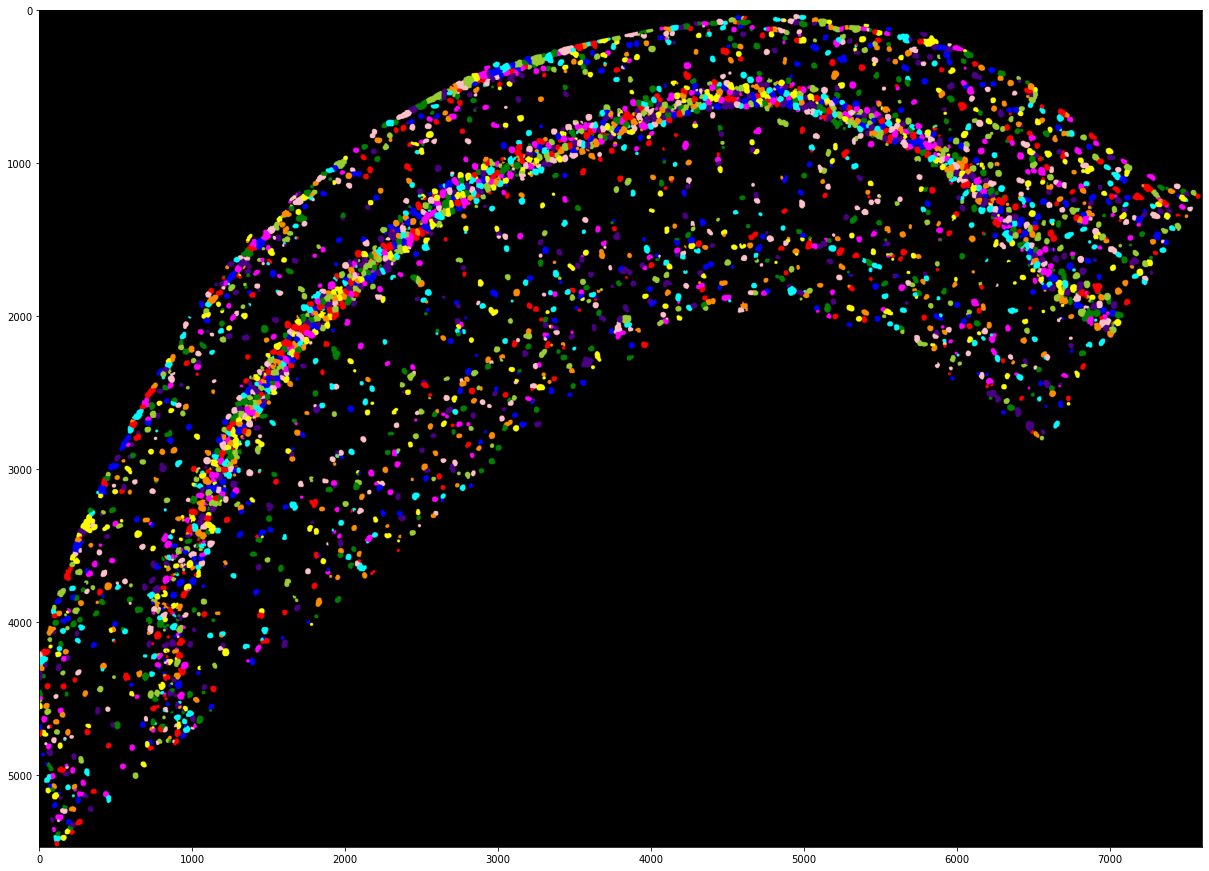

In [5]:
rgb_label_image = skimage.color.label2rgb(coo.toarray(), bg_label=0)
_dpi = 72
plt.figure(figsize=(1500/_dpi, 1500/_dpi), dpi=_dpi)
imgplot = plt.imshow(rgb_label_image)
plt.show()

### 1.2. The spots

The spots should be a dataframe with column names: 'Gene', 'x', 'y'. 

In [6]:
spots_file = pciSeq.utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/iss/spots.csv?raw=true')
iss_spots = pd.read_csv(spots_file)
iss_spots.head()

,Gene,x,y
0,Cxcl14,110,5457
1,Plp1,-1,4735
2,Plp1,-1,4725
3,Id2,-1,4478
4,Enpp2,-1,4455


### **Caution!**
It is important to make sure that the spots and the segmentation array are not misaligned. If the **orign** of the ROI containing our spots is not at [0, 0] then the spot coords must be shifted and/or flipped in such a manner that they are inline with the segmentation data.

We can overlay the spots to the cells to quicly check whether this holds

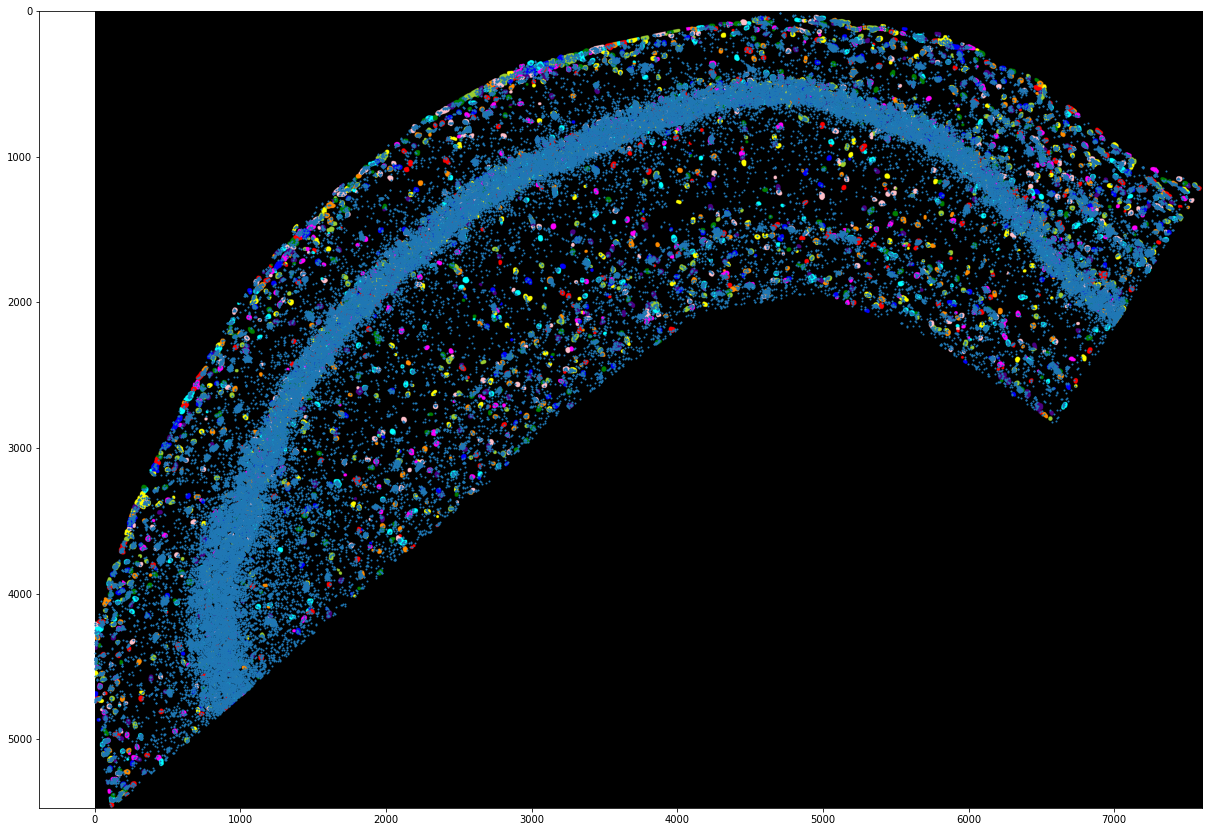

In [7]:
my_dpi = 72
plt.figure(figsize=(1500/my_dpi, 1500/my_dpi), dpi=my_dpi)
imgplot = plt.imshow(rgb_label_image)
plt.scatter(iss_spots.x, iss_spots.y, s=1)
plt.show()

### 1.3. The single cell data

This is another dataframe with columns the cell classes and rows the genes. The expression data are UMI counts as they come from single cell sequencing.


##### A note on the gene inefficiency
It is worth highlighting here that if the counts are not UMI (could be FPKM for example) then you need to take some action. FPKM counts are orders of magnitude larger than UMI, hence you could either:

* Divide the single cell data by something like 1000 or
* Divide the value of the 'Inefficiency' hyperparameter by 1000

In general, regardless UMI or FPKM, a rule of thumb to set the initial value of the gene inefficiency hyperparamter is to keep in mind that it tries to express how well a gene is detected, hence setting it to the ratio of actual/predicted counts sounds like a reasonable choice. Here, actual means the gene counts you expect from the data and predicted its counterpart from the single cell matrix. The initial value for the gene inefficiency doesnt have to be dead right, it is just a starting point to get the algorithm started. But if it is 1000 times off then it wont be able to compare the infered cell gene counts to those from the single cell data and all cells quite likely will be classed as Zero class.

In [8]:
sc_file = pciSeq.utils.load_from_url('https://github.com/acycliq/pciSeq/blob/dev/pciSeq/data/mouse/ca1/scRNA/scRNAseq.csv.gz?raw=true')
scRNAseq = pd.read_csv(sc_file, header=None, index_col=0, compression='gzip', dtype=object)
scRNAseq = scRNAseq.rename(columns=scRNAseq.iloc[0], copy=False).iloc[1:]
scRNAseq = scRNAseq.astype(float).astype(np.uint32)

In [9]:
scRNAseq.head()

,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,PC.CA1.1,...,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1,Sst.Nos1
0,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm1992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Caution!**
It is worth noting that pciSeq internally works on the aggregated (mean) gene expressions from the single cell data. For any given gene, pciSeq will group the raw single cell data that the user feeds-in, by the cell type (aka class, aka cluster) to get the average counts per cell type. Hence, the headers (ie column names) of the single cell dataframe should reflect the cells' cell types. Then the code will group the dataframe by the cell type to yield an aggregated by the mean dataframe of shape numGenes-by-numCellTypes. 

If the column names of the single cell dataframe that is passed-in to the fit() method are not the cell type labels, the group-by operator will not produce the correct mean gene expression per cell type.  

## 2. Cell typing

First, setup the logger

In [10]:
pciSeq.attach_to_log()

We can now do the cell typing. To launch the viewer you need to set the 'launch_viewer' key to true and pass it in the options arg. You may also find some notes at the bottom of this notebook useful, epsecially of you want to use your own data.

In [ ]:
opts = {'launch_viewer': True} # Set this to True to launch the viewer after convergence 
cellData, geneData = pciSeq.fit(iss_spots, coo, scRNAseq, opts)

[2023-03-10 15:18:21] INFO    (app.py:160)  launch_viewer is set to True
INFO:pciSeq: launch_viewer is set to True
[2023-03-10 15:18:21] INFO    (app.py: 89)  Preprocessing data
INFO:pciSeq: Preprocessing data
[2023-03-10 15:18:21] INFO    (spot_labels.py: 64)  Number of spots passed-in: 72336
INFO:pciSeq: Number of spots passed-in: 72336
[2023-03-10 15:18:21] INFO    (spot_labels.py: 65)  Number of segmented cells: 3481
INFO:pciSeq: Number of segmented cells: 3481
[2023-03-10 15:18:21] INFO    (spot_labels.py: 66)  Segmentation array implies that image has width: 7602px and height: 5471px
INFO:pciSeq: Segmentation array implies that image has width: 7602px and height: 5471px
[2023-03-10 15:18:36] INFO    (datatypes.py:386)  Single cell data passed-in have 27998 genes and 5712 cells
INFO:pciSeq: Single cell data passed-in have 27998 genes and 5712 cells
[2023-03-10 15:18:36] INFO    (datatypes.py:388)  Single cell data: Keeping counts for the gene panel of 92 only
INFO:pciSeq: Single c

 * Serving Flask app 'pciSeq.src.viewer.run_flask'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5916
INFO:werkzeug:Press CTRL+C to quit


Platform is Linux
Chrome path: /usr/bin/google-chrome
Could not open browser


## Notes
- The viewer should now be running on another tab. The code is inside the pciSeq folder of your system's temp directory (unless you have set 'output_path' to a folder of your choice and fed that in the options arg when you called pciSeq.fit()). You can copy the folder outside the temp folder and launch the viewer from any other location by running the index.html file. You should need to serve the pciSeq folder but most modern IDEs like pycharm or vscode to that for you behind the scenes.
- The viewer is controlled by three files. If you want to use your own data these are the files you have to edit. The links below point to GitHub but a copy of these is saved by default into yout temp directory
    - [config.js](https://github.com/acycliq/pciSeq/blob/master/pciSeq/static/2D/viewer/js/config.js)
    - [classConfig.js](https://github.com/acycliq/pciSeq/blob/master/pciSeq/static/2D/viewer/js/classConfig.js)
    - [glyphConfig.js](https://github.com/acycliq/pciSeq/blob/master/pciSeq/static/2D/viewer/js/glyphConfig.js)

If you have launched the viewer, everything behing this line will not be executed. The viewer is a blocking operation